# Russian Sign Language Recognition
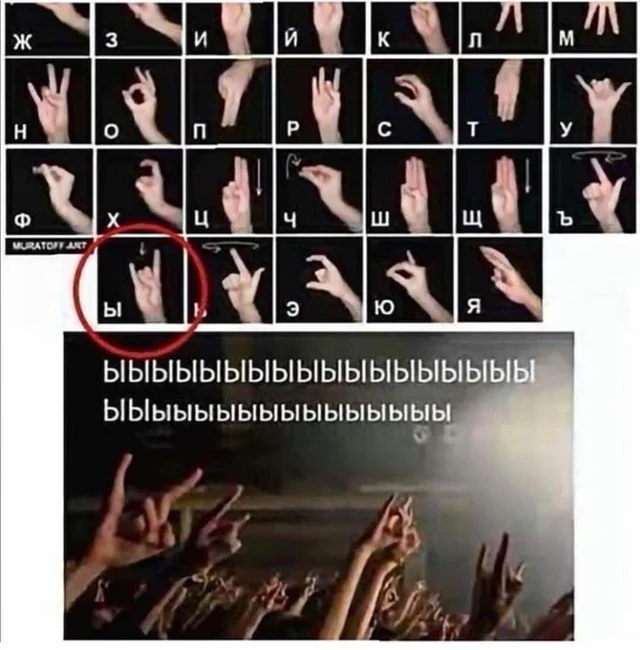

Today we're going to solve a computer vision problem and build russian sign language recognition model, using Python, OpenCV, PyTorch, TorchVision and etc.

# Table of contents
1. Importing libraries
2. Loading data
3. Model building
4. Training
5. Evaluating
6. Final results

## Importing libraries

In [1]:
import os
import PIL
import torch
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, Dict, List
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

sns.set_style("darkgrid")

RANDOM_SEED = 23

In [2]:
transforms.__class__

module

## Loading data

Getting paths

In [3]:
current_directory_path = Path.cwd()
data_path = current_directory_path / "data"

train_path = data_path / "train"
valid_path = data_path / "valid"
test_path = data_path / "test"

Let's watch some images

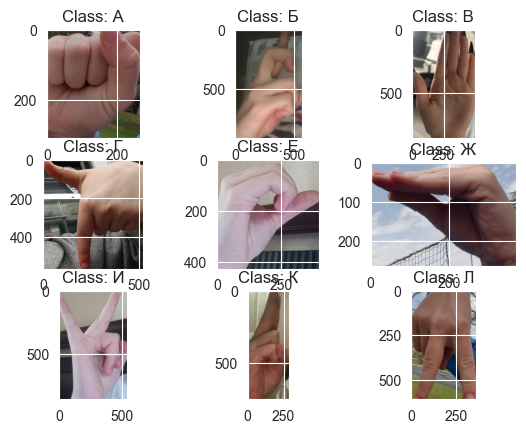

In [4]:
classes = os.listdir(train_path)
images_to_watch = []

# Let's see first 9 classes and their first images
for i in range(9):
    class_path = train_path / classes[i]
    image_path = class_path / os.listdir(class_path)[0]
    images_to_watch.append(image_path)

fig, axs = plt.subplots(ncols=3, nrows=3)
for i in range(9):
    y = i // 3
    x = i % 3
    axs[y, x].imshow(PIL.Image.open(images_to_watch[i]))
    axs[y, x].set_title(f"Class: {classes[i]}")

plt.show()

We got images with different sizes. So, we'll need to add a transform.

Now, let's prepare dataloaders

In [5]:
def create_dataloaders(
    train_path: Path | str,
    valid_path: Path | str,
    test_path: Path | str,
    train_transforms: torch.nn.Module,
    valid_transforms: torch.nn.Module,
    test_transforms: torch.nn.Module,
    batch_size: int = 4,
    num_workers: int = 0
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Creates and returns dataloaders 
    for train, valid and test dataset
    """
    
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms, target_transform=None)
    valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_transforms)
    test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)

    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )

    valid_dataloader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )

    return (train_dataloader, valid_dataloader, test_dataloader)

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [7]:
train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    train_path=train_path,
    valid_path=valid_path,
    test_path=test_path,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    test_transforms=test_transforms
)

## Model building
Let's create basic CNN model

In [8]:
from torch import nn

class RSLRmodel(nn.Module):
    def __init__(self):
        super().__init__()

        # 3x64x64 => 32x32x32
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, 
                out_channels=32,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        # 32x32x32 => 32x16x16
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, 
                out_channels=32,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        # 32x16x16 => 32x8x8
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, 
                out_channels=32,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        # 64x8x8 => 2048 => 25
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=.5),
            nn.Linear(
                in_features=2048,
                out_features=25,
            )
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv_block_1(x)
        x2 = self.conv_block_2(x1)
        x3 = self.conv_block_3(x2)
        return self.classifier(x3)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(RANDOM_SEED)
model = RSLRmodel().to(device).to(memory_format=torch.channels_last)
summary(model=model, input_size=(4, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
RSLRmodel                                [4, 25]                   --
├─Sequential: 1-1                        [4, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [4, 32, 64, 64]           896
│    └─BatchNorm2d: 2-2                  [4, 32, 64, 64]           64
│    └─ReLU: 2-3                         [4, 32, 64, 64]           --
│    └─MaxPool2d: 2-4                    [4, 32, 32, 32]           --
├─Sequential: 1-2                        [4, 32, 16, 16]           --
│    └─Conv2d: 2-5                       [4, 32, 32, 32]           9,248
│    └─BatchNorm2d: 2-6                  [4, 32, 32, 32]           64
│    └─ReLU: 2-7                         [4, 32, 32, 32]           --
│    └─MaxPool2d: 2-8                    [4, 32, 16, 16]           --
├─Sequential: 1-3                        [4, 32, 8, 8]             --
│    └─Conv2d: 2-9                       [4, 32, 16, 16]           9,248
│    └─B

## Training model

In [10]:
alpha = 1e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=alpha, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
def accuracy(
    pred: torch.Tensor, 
    target: torch.Tensor
) -> float:
    """
    Calculates accuracy (amount of prediction and target matches)
    """
    return (pred == target).sum().item() / len(pred)

In [12]:
def train_step(
    model: torch.nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: str,
) -> Tuple[float, float]:
    """
    Performs full train epoch
    """
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (features, targets) in enumerate(dataloader):
        features, targets = features.to(device).to(memory_format=torch.channels_last), targets.to(device)

        y_pred_logits = model(features)
        loss = criterion(y_pred_logits, targets)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_labels = y_pred_logits.argmax(dim=1)
        train_acc += accuracy(pred=y_pred_labels, target=targets)
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return (train_loss, train_acc)

In [13]:
def test_step(
    model: torch.nn.Module,
    dataloader: DataLoader,
    criterion: torch.nn.Module,
    device: str,
) -> Tuple[float, float]:
    """
    Performs full validation/test epoch
    """
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (features, targets) in enumerate(dataloader):
            features, targets = features.to(device).to(memory_format=torch.channels_last), targets.to(device)

            y_pred_logits = model(features)
            loss = criterion(y_pred_logits, targets)
            test_loss += loss.item()

            y_pred_labels = y_pred_logits.argmax(dim=1)
            test_acc += accuracy(pred=y_pred_labels, target=targets)
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return (test_loss, test_acc)

In [14]:
def save_model(
    model: torch.nn.Module,
    directory: Path | str,
    filename: str = None,
    epoch: int | str = None
) -> None:
    if not filename and not epoch:
        filename = f"rslr_model.pth"
    elif not filename:
        filename = f"rslr_model_epoch_{epoch}.pth"
    
    save_path = os.path.join(directory, filename)
    torch.save(obj=model.state_dict(), f=save_path)

In [15]:
def train(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: str,
    epochs: int
) -> Dict[str, List[float]]:
    """
    Trains model and returns metrics
    """
    with mlflow.start_run():
        result = {
            "train_acc": [],
            "train_loss": [],
            "valid_acc": [],
            "valid_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = train_step(
                model=model,
                dataloader=train_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                device=device
            )

            valid_loss, valid_acc = test_step(
                model=model,
                dataloader=valid_dataloader,
                criterion=criterion,
                device=device
            )

            if (epoch + 1) % 10 == 0:
                save_model(model=model, directory=current_directory_path/"models", epoch=epoch+1)

            print(f"Epoch = {epoch+1} | {train_loss=:.3f} | {train_acc=:.3f} | {valid_loss=:.3f} | {valid_acc=:.3f}")

            result["train_acc"].append(train_acc)
            result["train_loss"].append(train_loss)
            result["valid_acc"].append(valid_acc)
            result["valid_loss"].append(valid_loss)

            mlflow.log_metrics(
                metrics={
                    "Train accuracy": train_acc,
                    "Validation accuracy": valid_acc,
                    "Train loss": train_loss,
                    "Validation loss": valid_loss
                },
                step=epoch+1
            )
        
        mlflow.pytorch.log_model(pytorch_model=model, name="model")
        mlflow.set_tags({
            "model type": "cnn",
            "dataset": "RSL dataset",
            "framework": "pytorch"
        })

        return result

In [16]:
mlflow.set_experiment("Russian Sign Language Recignition")
mlflow.enable_system_metrics_logging()

epochs = 50
res = train(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs
)

d:\Programming\Projects\Russian Sign Language Recognition\venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/12/02 13:00:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
  2%|▏         | 1/50 [00:19<15:34, 19.08s/it]

Epoch = 1 | train_loss=1.882 | train_acc=0.486 | valid_loss=1.082 | valid_acc=0.682


  4%|▍         | 2/50 [00:36<14:35, 18.24s/it]

Epoch = 2 | train_loss=0.806 | train_acc=0.773 | valid_loss=0.840 | valid_acc=0.771


  6%|▌         | 3/50 [00:53<13:55, 17.78s/it]

Epoch = 3 | train_loss=0.511 | train_acc=0.854 | valid_loss=0.770 | valid_acc=0.789


  8%|▊         | 4/50 [01:12<13:43, 17.89s/it]

Epoch = 4 | train_loss=0.419 | train_acc=0.871 | valid_loss=0.669 | valid_acc=0.830


 10%|█         | 5/50 [01:30<13:36, 18.15s/it]

Epoch = 5 | train_loss=0.354 | train_acc=0.897 | valid_loss=0.907 | valid_acc=0.781


 12%|█▏        | 6/50 [01:49<13:22, 18.23s/it]

Epoch = 6 | train_loss=0.279 | train_acc=0.909 | valid_loss=0.707 | valid_acc=0.830


 14%|█▍        | 7/50 [02:07<13:05, 18.27s/it]

Epoch = 7 | train_loss=0.268 | train_acc=0.914 | valid_loss=0.692 | valid_acc=0.839


 16%|█▌        | 8/50 [02:25<12:48, 18.30s/it]

Epoch = 8 | train_loss=0.246 | train_acc=0.920 | valid_loss=0.705 | valid_acc=0.853


 18%|█▊        | 9/50 [02:44<12:31, 18.32s/it]

Epoch = 9 | train_loss=0.198 | train_acc=0.940 | valid_loss=0.603 | valid_acc=0.865


 20%|██        | 10/50 [03:02<12:13, 18.33s/it]

Epoch = 10 | train_loss=0.183 | train_acc=0.941 | valid_loss=0.600 | valid_acc=0.853


 22%|██▏       | 11/50 [03:20<11:54, 18.33s/it]

Epoch = 11 | train_loss=0.190 | train_acc=0.938 | valid_loss=0.493 | valid_acc=0.879


 24%|██▍       | 12/50 [03:39<11:37, 18.35s/it]

Epoch = 12 | train_loss=0.171 | train_acc=0.946 | valid_loss=0.567 | valid_acc=0.866


 26%|██▌       | 13/50 [03:57<11:19, 18.37s/it]

Epoch = 13 | train_loss=0.130 | train_acc=0.956 | valid_loss=0.552 | valid_acc=0.866


 28%|██▊       | 14/50 [04:16<11:05, 18.49s/it]

Epoch = 14 | train_loss=0.124 | train_acc=0.960 | valid_loss=0.521 | valid_acc=0.879


 30%|███       | 15/50 [04:35<10:53, 18.67s/it]

Epoch = 15 | train_loss=0.127 | train_acc=0.960 | valid_loss=0.541 | valid_acc=0.875


 32%|███▏      | 16/50 [04:53<10:29, 18.51s/it]

Epoch = 16 | train_loss=0.148 | train_acc=0.953 | valid_loss=0.583 | valid_acc=0.884


 34%|███▍      | 17/50 [05:11<10:04, 18.33s/it]

Epoch = 17 | train_loss=0.126 | train_acc=0.961 | valid_loss=0.544 | valid_acc=0.866


 36%|███▌      | 18/50 [05:29<09:45, 18.29s/it]

Epoch = 18 | train_loss=0.115 | train_acc=0.962 | valid_loss=0.616 | valid_acc=0.860


 38%|███▊      | 19/50 [05:48<09:27, 18.32s/it]

Epoch = 19 | train_loss=0.109 | train_acc=0.964 | valid_loss=0.556 | valid_acc=0.875


 40%|████      | 20/50 [06:07<09:14, 18.50s/it]

Epoch = 20 | train_loss=0.098 | train_acc=0.966 | valid_loss=0.499 | valid_acc=0.879


 42%|████▏     | 21/50 [06:27<09:10, 18.98s/it]

Epoch = 21 | train_loss=0.098 | train_acc=0.966 | valid_loss=0.536 | valid_acc=0.893


 44%|████▍     | 22/50 [06:46<08:51, 18.97s/it]

Epoch = 22 | train_loss=0.080 | train_acc=0.972 | valid_loss=0.520 | valid_acc=0.884


 46%|████▌     | 23/50 [07:05<08:36, 19.13s/it]

Epoch = 23 | train_loss=0.069 | train_acc=0.979 | valid_loss=0.559 | valid_acc=0.884


 48%|████▊     | 24/50 [07:25<08:23, 19.36s/it]

Epoch = 24 | train_loss=0.077 | train_acc=0.975 | valid_loss=0.538 | valid_acc=0.893


 50%|█████     | 25/50 [07:44<08:03, 19.35s/it]

Epoch = 25 | train_loss=0.096 | train_acc=0.967 | valid_loss=0.557 | valid_acc=0.888


 52%|█████▏    | 26/50 [08:04<07:44, 19.35s/it]

Epoch = 26 | train_loss=0.072 | train_acc=0.975 | valid_loss=0.651 | valid_acc=0.884


 54%|█████▍    | 27/50 [08:24<07:29, 19.53s/it]

Epoch = 27 | train_loss=0.081 | train_acc=0.972 | valid_loss=0.569 | valid_acc=0.888


 56%|█████▌    | 28/50 [08:43<07:06, 19.40s/it]

Epoch = 28 | train_loss=0.085 | train_acc=0.973 | valid_loss=0.597 | valid_acc=0.875


 58%|█████▊    | 29/50 [09:02<06:46, 19.34s/it]

Epoch = 29 | train_loss=0.065 | train_acc=0.981 | valid_loss=0.607 | valid_acc=0.884


 60%|██████    | 30/50 [09:21<06:25, 19.28s/it]

Epoch = 30 | train_loss=0.074 | train_acc=0.970 | valid_loss=0.697 | valid_acc=0.884


 62%|██████▏   | 31/50 [09:40<06:06, 19.28s/it]

Epoch = 31 | train_loss=0.056 | train_acc=0.983 | valid_loss=0.661 | valid_acc=0.884


 64%|██████▍   | 32/50 [09:59<05:42, 19.01s/it]

Epoch = 32 | train_loss=0.069 | train_acc=0.980 | valid_loss=0.523 | valid_acc=0.902


 66%|██████▌   | 33/50 [10:17<05:19, 18.81s/it]

Epoch = 33 | train_loss=0.081 | train_acc=0.976 | valid_loss=0.628 | valid_acc=0.893


 68%|██████▊   | 34/50 [10:36<04:59, 18.71s/it]

Epoch = 34 | train_loss=0.078 | train_acc=0.973 | valid_loss=0.653 | valid_acc=0.875


 70%|███████   | 35/50 [10:54<04:39, 18.63s/it]

Epoch = 35 | train_loss=0.058 | train_acc=0.983 | valid_loss=0.573 | valid_acc=0.888


 72%|███████▏  | 36/50 [11:12<04:19, 18.51s/it]

Epoch = 36 | train_loss=0.062 | train_acc=0.980 | valid_loss=0.665 | valid_acc=0.902


 74%|███████▍  | 37/50 [11:31<04:00, 18.52s/it]

Epoch = 37 | train_loss=0.066 | train_acc=0.979 | valid_loss=0.557 | valid_acc=0.888


 76%|███████▌  | 38/50 [11:49<03:42, 18.52s/it]

Epoch = 38 | train_loss=0.047 | train_acc=0.983 | valid_loss=0.654 | valid_acc=0.879


 78%|███████▊  | 39/50 [12:08<03:25, 18.73s/it]

Epoch = 39 | train_loss=0.035 | train_acc=0.990 | valid_loss=0.626 | valid_acc=0.911


 80%|████████  | 40/50 [12:27<03:07, 18.76s/it]

Epoch = 40 | train_loss=0.058 | train_acc=0.980 | valid_loss=0.689 | valid_acc=0.875


 82%|████████▏ | 41/50 [12:47<02:52, 19.15s/it]

Epoch = 41 | train_loss=0.044 | train_acc=0.984 | valid_loss=0.648 | valid_acc=0.902


 84%|████████▍ | 42/50 [13:06<02:33, 19.13s/it]

Epoch = 42 | train_loss=0.053 | train_acc=0.982 | valid_loss=0.649 | valid_acc=0.897


 86%|████████▌ | 43/50 [13:26<02:13, 19.11s/it]

Epoch = 43 | train_loss=0.044 | train_acc=0.986 | valid_loss=0.510 | valid_acc=0.906


 88%|████████▊ | 44/50 [13:44<01:54, 19.07s/it]

Epoch = 44 | train_loss=0.034 | train_acc=0.989 | valid_loss=0.541 | valid_acc=0.902


 90%|█████████ | 45/50 [14:04<01:35, 19.07s/it]

Epoch = 45 | train_loss=0.059 | train_acc=0.982 | valid_loss=0.738 | valid_acc=0.888


 92%|█████████▏| 46/50 [14:23<01:16, 19.11s/it]

Epoch = 46 | train_loss=0.053 | train_acc=0.983 | valid_loss=0.518 | valid_acc=0.893


 94%|█████████▍| 47/50 [14:41<00:56, 18.90s/it]

Epoch = 47 | train_loss=0.055 | train_acc=0.980 | valid_loss=0.681 | valid_acc=0.884


 96%|█████████▌| 48/50 [15:00<00:37, 18.98s/it]

Epoch = 48 | train_loss=0.053 | train_acc=0.981 | valid_loss=0.659 | valid_acc=0.875


 98%|█████████▊| 49/50 [15:20<00:19, 19.27s/it]

Epoch = 49 | train_loss=0.043 | train_acc=0.986 | valid_loss=0.614 | valid_acc=0.879


100%|██████████| 50/50 [15:40<00:00, 18.82s/it]

Epoch = 50 | train_loss=0.050 | train_acc=0.983 | valid_loss=0.585 | valid_acc=0.893



2025/12/02 13:15:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/02 13:15:57 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/12/02 13:15:57 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Let's check past metrics

In [17]:
import pandas as pd
metrics = pd.DataFrame(res)
metrics.head()

,train_acc,train_loss,valid_acc,valid_loss
0,0.485822,1.881759,0.681548,1.082045
1,0.772684,0.806441,0.770833,0.840201
2,0.853970,0.510795,0.788690,0.770220
3,0.871456,0.419223,0.830357,0.668695
4,0.897448,0.354265,0.781250,0.907349


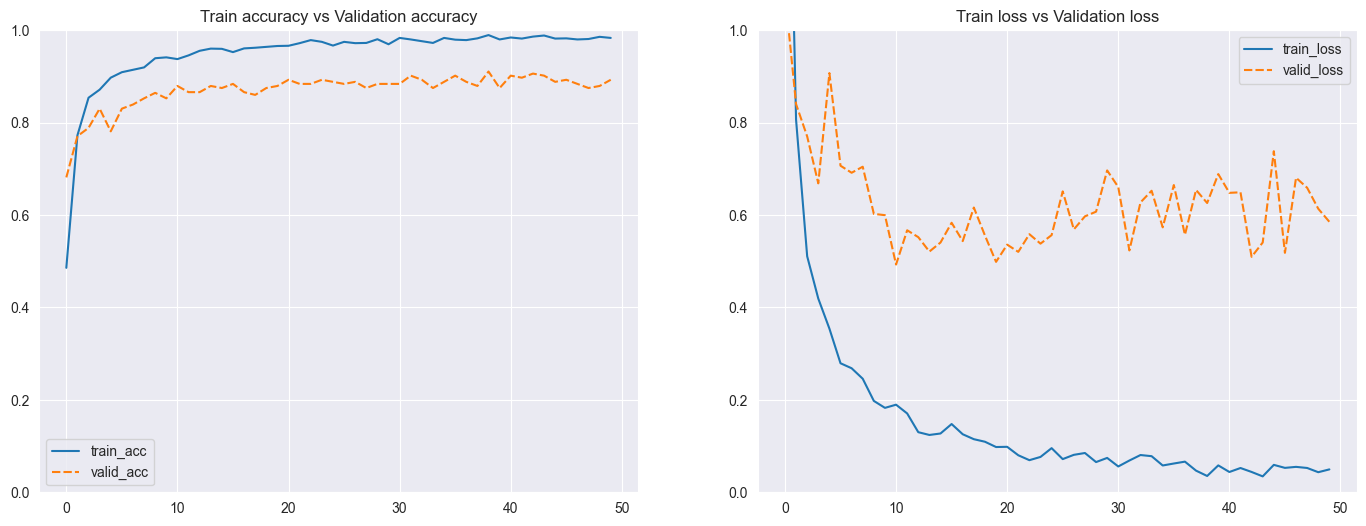

In [20]:

fig, axs = plt.subplots(ncols=2, figsize=(17, 6))
sns.lineplot(metrics[["train_acc", "valid_acc"]], ax=axs[0])
sns.lineplot(metrics[["train_loss", "valid_loss"]], ax=axs[1])
axs[0].set_title("Train accuracy vs Validation accuracy")
axs[0].set_ylim(0, 1)
axs[1].set_title("Train loss vs Validation loss")
axs[1].set_ylim(0, 1)
plt.show()

As we see in plots above, validation loss doesn't grow too much. It's stays about 0.6 value.
<br>It means, that we dont overfit. That is good.

But plots show, that train data cannot represent all "features" that can take place in validation dataset

Let's try on test data

In [117]:
test_loss, test_acc = test_step(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion,
    device=device
)

print(f"{test_loss=:.2f}, {test_acc=:.2f}")

test_loss=0.45, test_acc=0.92


Nice! 92% accuracy with loss lower than validation. 
<br> Let's check ROC AUC score. Since we work with milticlass model, we'll use macro ROC AUC score

In [ ]:
from torchmetrics.classification import MulticlassROC, MulticlassAUROC

def calc_and_plot_roc_auc(
    model: torch.nn.Module,
    dataloader: DataLoader,
    device: str
) -> float:
    # Evaluate model
    model.eval()
    with torch.inference_mode():
        # Setup ROC and AUC
        classes = dataloader.dataset.classes
        metric_roc = MulticlassROC(num_classes=len(classes), average=None) # ROC per-class
        metric_auroc = MulticlassAUROC(num_classes=len(classes), average="macro") # macro-averaged AUC

        for batch, (features, target) in enumerate(dataloader):
            features, target = features.to(device).to(memory_format=torch.channels_last), target.to(device)

            pred_logits = model(features)
            metric_roc.update(pred_logits, target)
            metric_auroc.update(pred_logits, target)

        fig, ax = metric_roc.plot(score=True)
        fig.set_size_inches(9, 9)
        plt.title(f"Multiclass ROC | Macro-averaged AUROC score: {metric_auroc.compute():.3f}")
        
        # Clarify legend classes
        _, labels = plt.gca().get_legend_handles_labels()
        new_labels = []
        for i, label in enumerate(labels):
            score_part = label.split(' ')[1]
            new_labels.append(f"Буква \'{classes[i]}\' {score_part}")
        plt.legend(new_labels)
        plt.show()

    

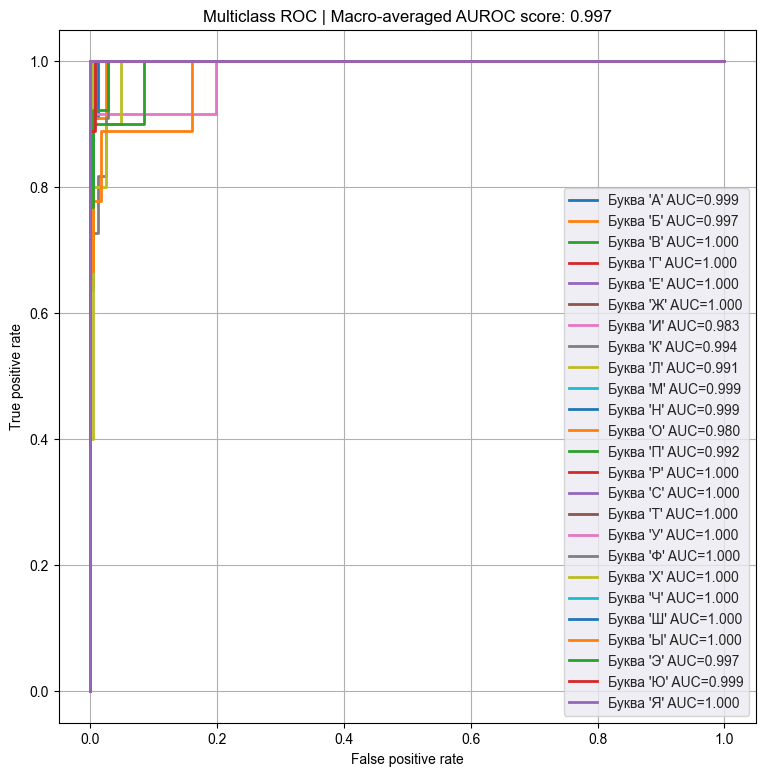

In [131]:
calc_and_plot_roc_auc(
    model=model,
    dataloader=test_dataloader,
    device=device
)

Finally, we got such a decent AUC score - 99.7%